In [25]:
import pandas as pd
import numpy as np

# NLTK Packages
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle('data/BGGDataGenreEncoded.pkl')

In [3]:
cols = list(df.columns.values)
genre_cols = cols[1:]
print(genre_cols)

['Abstract', "Children's", 'Family', 'Strategy', 'Thematic', 'Wargames']


In [4]:
X = df.drop(genre_cols, axis=1)
y = df[genre_cols]

In [5]:
X

,description
0,gloomhaven is a game of euro inspired tactical...
1,pandemic legacy is a co operative campaign gam...
2,gloomhaven jaws of the lion is a standalone ga...
3,twilight imperium fourth edition is a game of ...
4,star wars rebellion is a board game of epic co...
...,...
18358,knights poker is the new board game from the w...
18359,gekitai repel or push away is a in a row game ...
18360,gekitai repel or push away is a in a row game ...
18361,digit draughts is a set of three related games...


In [6]:
y

,Abstract,Children's,Family,Strategy,Thematic,Wargames
0,0,0,0,1,1,0
1,0,0,0,1,1,0
2,0,0,0,1,1,0
3,0,0,0,1,1,0
4,0,0,0,0,1,0
...,...,...,...,...,...,...
18358,1,0,0,0,0,0
18359,1,0,0,0,0,0
18360,1,0,0,0,0,0
18361,1,0,0,0,0,0


In [10]:
def tokenizer(text):
    """
    Tokenizes the document
    """
    return word_tokenize(text)

#Load up our stop words
stop_words = stopwords.words('english')
#Adds stuff to our stop words list
stop_words.extend(['.',','])

## This function can improve, simplify. Look into Text Data Lecture
def remove_stopwords(list_of_tokens):
    """
    Removes stopwords
    """
    cleaned_tokens = []

    for token in list_of_tokens:
        if token in stop_words: continue
        cleaned_tokens.append(token)

    return cleaned_tokens

def stemmer(list_of_tokens):
    '''
    Takes in an input which is a list of tokens, and spits out a list of stemmed tokens.
    '''

    stemmed_tokens_list = []

    for i in list_of_tokens:

        token = PorterStemmer().stem(i)
        stemmed_tokens_list.append(token)

    return stemmed_tokens_list

def lemmatizer(list_of_tokens):

    lemmatized_tokens_list = []

    for i in list_of_tokens:
        token = WordNetLemmatizer().lemmatize(i)
        lemmatized_tokens_list.append(token)

    return lemmatized_tokens_list


def the_untokenizer(token_list):
    '''
    Returns all the tokenized words in the list to one string.
    Used after the pre processing, such as removing stopwords, and lemmatizing.
    '''
    return " ".join(token_list)

def cleaning_our_texts(text):

    cleaned_texts = []
    num_texts = len(text)

    for i in text.index:
        that_string = text[i]
        tokenized_list = tokenizer(that_string)
        removed_stopwords = remove_stopwords(tokenized_list)
        stemmed_words = stemmer(removed_stopwords)
        lemmatized_words = lemmatizer(stemmed_words)
        back_to_string = the_untokenizer(lemmatized_words)

        cleaned_texts.append(back_to_string)

    return cleaned_texts

In [11]:
X['description'] = cleaning_our_texts(X['description'])

In [12]:
X

,description
0,gloomhaven game euro inspir tactic combat pers...
1,pandem legaci co oper campaign game overarch s...
2,gloomhaven jaw lion standalon game take place ...
3,twilight imperium fourth edit game galact conq...
4,star war rebellion board game epic conflict ga...
...,...
18358,knight poker new board game world lead board g...
18359,gekitai repel push away row game play x grid p...
18360,gekitai repel push away row game play x grid p...
18361,digit draught set three relat game play use eq...


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

In [71]:
g_count_train = []
g_count_test = []
genres = []

for g in y.columns:
    genres.append(g)
    g_count_train.append(y_train[g].value_counts()[1])
    g_count_test.append(y_test[g].value_counts()[1])

genre_counts_train = dict(zip(genres, g_count_train))
genre_counts_test = dict(zip(genres, g_count_test))

dfg_train = pd.DataFrame.from_dict(genre_counts_train,orient='index')
dfg_train = dfg_train.reset_index()
dfg_train.columns = ['genre','count']
dfg_train = dfg_train.sort_values('count', ascending=False)

dfg_test = pd.DataFrame.from_dict(genre_counts_test,orient='index')
dfg_test = dfg_test.reset_index()
dfg_test.columns = ['genre','count']
dfg_test = dfg_test.sort_values('count', ascending=False)

In [72]:
tot_train = dfg_train['count'].sum()
tot_test = dfg_test['count'].sum()

dfg_train['perc'] = dfg_train['count']/tot_train
dfg_train['split'] = "Train"
dfg_test['perc'] = dfg_test['count']/tot_test
dfg_test['split'] = "Test"

comb_df = pd.concat([dfg_train,dfg_test])

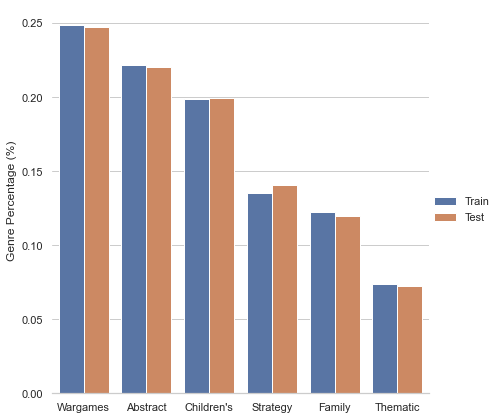

In [73]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=comb_df, kind="bar",
    x="genre", y="perc", hue="split", height=6
)
g.despine(left=True)
g.set_axis_labels("", "Genre Percentage (%)")
g.legend.set_title("")

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate the Vectorizer
# min_df at 20 - token should appear in at least 20 documents to be counted
tfidf = TfidfVectorizer(min_df=10) #, ngram_range=(1,3))

# Fit the vectorizer to the training data
tfidf.fit(X_train['description'])

# Transform both train and test sets
X_train_tfidf = tfidf.transform(X_train['description'])
X_test_tfidf = tfidf.transform(X_test['description'])

In [75]:
import joblib
joblib.dump(tfidf, 'data/my_tfidf_min10.pkl')

['data/my_tfidf_min10.pkl']

In [76]:
# Create new dataframe with the index of X_train, columns as the content of X_train_transformed token/feature names
X_train_transformed_df = pd.DataFrame(X_train_tfidf.toarray(), index=X_train.index, columns=tfidf.get_feature_names())
X_train_transformed_df

,aa,ab,abacu,abandon,abbey,abbrevi,abc,abil,abl,aboard,...,zhukov,zip,ziploc,ziplock,zoc,zombi,zone,zoo,zu,zulu
7921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
# Create new dataframe with the index of X_test, columns as the content of X_test_transformed token/feature names
X_test_transformed_df = pd.DataFrame(X_test_tfidf.toarray(), index=X_test.index, columns=tfidf.get_feature_names())
X_test_transformed_df

,aa,ab,abacu,abandon,abbey,abbrevi,abc,abil,abl,aboard,...,zhukov,zip,ziploc,ziplock,zoc,zombi,zone,zoo,zu,zulu
11809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
7834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.176951,0.0,0.0,0.0,0.0,0.0,0.0
2993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
11859,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
16534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
15123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
train_df_export = X_train_transformed_df.copy()
train_df_export = train_df_export.merge(y_train, on=train_df_export.index)
train_df_export = train_df_export.set_index(['key_0'])
train_df_export.index.name = None
train_df_export

,aa,ab,abacu,abandon,abbey,abbrevi,abc,abil,abl,aboard,...,zone,zoo,zu,zulu,Abstract,Children's,Family,Strategy,Thematic,Wargames
7921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,1,0,0
311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,1,0,1,0
17272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,0,0,0,0,0
7405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,1,0,0,0
7553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,1
11964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,1
5390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,1,0,0,0,0
860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,1,1


In [86]:
test_df_export = X_test_transformed_df.copy()
test_df_export = test_df_export.merge(y_test, on=test_df_export.index)
test_df_export = test_df_export.set_index(['key_0'])
test_df_export.index.name = None
test_df_export

,aa,ab,abacu,abandon,abbey,abbrevi,abc,abil,abl,aboard,...,zone,zoo,zu,zulu,Abstract,Children's,Family,Strategy,Thematic,Wargames
11809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,1
3993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,1,0,0,0,0
7834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,1,0,0
4708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,1,0,0,0,0
2993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,1
11859,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,1
16534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,0,0,0,0,0
15123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,0,0,0,0,0


In [87]:
pd.to_pickle(train_df_export, 'data/train_df.pkl')
pd.to_pickle(test_df_export, 'data/test_df.pkl')